# *Neural Network Approach*

# Imports 

In [ ]:
import kagglehub
from requests.exceptions import ChunkedEncodingError
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from skimage import exposure
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import pickle
from sklearn.decomposition import PCA
import seaborn as sns
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

## Load Data

In [28]:
# Load train data
train_data = np.load("/home/user_stel/image_assignment_2/data_nn/train_data.npz")
X_tr = train_data["X"]
y_tr = train_data["y"]

print("Shape of Training dataset:")
print(X_tr.shape, y_tr.shape)

# Load test data 
test_data = np.load("/home/user_stel/image_assignment_2/data_nn/test_data.npz")
X_te = test_data["X"]
y_te = test_data["y"]

print("Shape of Test dataset:")
print(X_te.shape, y_te.shape)

Shape of Training dataset:
(5216, 128, 128) (5216,)
Shape of Test dataset:
(624, 128, 128) (624,)


## Sequential Neural Network Architecture

Since our datasets consist of 5216 images for training and 624 for testing respectively, we will perform data augmentation on our training dataset before training our neural network because of the nature of our data and classification task and because of the relatively small to medium size of our dataset (5000). Data augmentation increases our training dataset size, helps our model to generalize better by exposing it to variations of the same class (normal or pneumonia) and reduces overfitting (on our first try before using data augmentation, we noticed overfitting in early stages at epoch 3 so we tried using the data augmentation approach to prevent the nn from overfitting). We will tune our neural network using the augmented training dataset and then we will validate our neural network using the held out set. Before we perform data augmentation, we will split our training set into training and validation sets in order to use the unaugmented 20% of the original training set for validation and then the data augmentation will be performed only to the 80% that will be used for training. After the training, we will evaluate the performance of our neural network on our (unaugmented) test dataset and we will compare the test accuracy with the accuracy obtained from the ml approach in order to determine which approach worked better for this specific classification task. 

### Data Augmentation

In [ ]:
# Add a channel dimension to make shape (N, 128, 128, 1)
X_tr = X_tr[..., np.newaxis]
X_te = X_te[..., np.newaxis]
print(X_tr.shape, X_te.shape)

# Split training dataset before data augmentation 
X_train, X_val, y_train, y_val = train_test_split(
    X_tr, y_tr, test_size=0.2, random_state=42, stratify=y_tr
)

(5216, 128, 128, 1) (624, 128, 128, 1)


In [30]:
# initialize data augmentation method
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  
)

In [ ]:
# Initialize NN architecture
model = Sequential([
    Input(shape=(128, 128, 1)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # or 2 classes + softmax if using categorical labels
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Train Neural Network

In [34]:
batch_size = 32

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_tr) // batch_size,
    epochs=10,
    validation_data=(X_val, y_val)
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 39s 233ms/step - accuracy: 0.7541 - loss: 0.5159 - val_accuracy: 0.8257 - val_loss: 0.3601
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 262ms/step - accuracy: 0.8605 - loss: 0.3037 - val_accuracy: 0.8736 - val_loss: 0.2854
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 293ms/step - accuracy: 0.8777 - loss: 0.2863 - val_accuracy: 0.9215 - val_loss: 0.1911
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 274ms/step - accuracy: 0.8983 - loss: 0.2464 - val_accuracy: 0.9052 - val_loss: 0.2243
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 262ms/step - accuracy: 0.9232 - loss: 0.1976 - val_accuracy: 0.9550 - val_loss: 0.1304
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 250ms/step - accuracy: 0.9149 - loss: 0.2056 - val_accuracy: 0.9569 - val_loss: 0.1078
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 244ms/step - accuracy: 0.9149 - loss: 0.2029 - val_accuracy: 0.9598 - val_loss: 0.0990
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 261ms/step - accuracy: 0.9351 - loss: 0

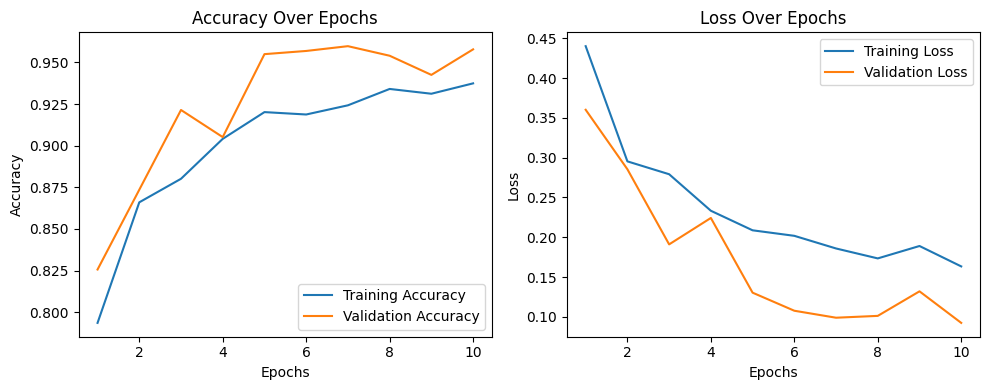

In [35]:
# Extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


From these plots we can exclude the following observations:<br>
1. Both training and validation accuracies steadily increase, indicating that our model generalizes well.
2. Both training and validation losses consistently decrease, indicating that our model is learning well, there is no divergence
3. Overall our model exhibits great generalization ability, good convergence behaviour and no signs of overfitting 

### Evaluate on test set 

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


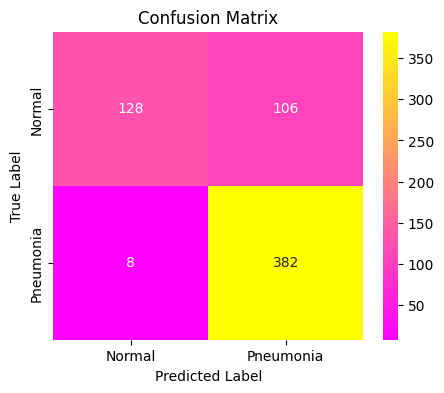

Final Test Accuracy: 0.8173
              precision    recall  f1-score   support

      Normal       0.94      0.55      0.69       234
   Pneumonia       0.78      0.98      0.87       390

    accuracy                           0.82       624
   macro avg       0.86      0.76      0.78       624
weighted avg       0.84      0.82      0.80       624



In [ ]:
# Predict class probabilities
y_proba = model.predict(X_te)

# Convert to class labels (since output is softmax)
y_pred = np.argmax(y_proba, axis=1)

# Confusion matrix
cm = confusion_matrix(y_te, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='spring', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
cm = confusion_matrix(y_te, y_pred)
acc = accuracy_score(y_te, y_pred)
print(f"Final Test Accuracy: {acc:.4f}")
print(classification_report(y_te, y_pred, target_names=['Normal', 'Pneumonia']))

In [40]:
test_loss, test_acc = model.evaluate(X_te, y_te)
print(f"Test Accuracy: {test_acc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6775 - loss: 0.9878
Test Accuracy: 0.8173


### Save Neural Network model architecture

In [ ]:
model.save("nn_model.h5")

## Results Interpretation

Our Neural Network approach resulted in **0.8173** accuracy, achieved on test dataset, which is higher than the test accuracy achieved by the best performing machine learning based classifier, **0.7740**. We adressed the issue of overfitting by applying data augmentation and trying dfferent architectures for out neural network and we managed to improve our scores. Our neural network was trained end-to-end on raw images, whereas our ml classifiers were trained on hog features extracted from those same images, this means that our neural network automatically learned various filters and on the other hand our ml classifiers, which relied on the ectracted HOG features, may have missed the context or more significant underlying patterns of the data. In our case, where the classification task involves chest X-rays, where pneumonia may appear in different lung regions, the overall spatial configuration matters, therefore it was not surprising that our neural network outperformed the ml classifiers, since it can learn local patterns and capture the whole structure better than the ml classifiers which only encode low level-gradients and they do not manage to capture all underlying patterns of the data. Our neural network also benefited from the data augmentation, which improved the neural networks generalization ability and prevented overfitting, whereas our ml classifiers trained only using the data available. Similar to the machine learning models, te neural network exhibits a tendency to classify pneumonia cases more accurately than normal cases. While the model performs well overall, it demonstrates a higher misclassification rate for normal images, suggesting a bias toward the pneumonia class.  